In [1]:
import os
import re
import glob
import math
import numpy             as np
import matplotlib.pyplot as plt
from datetime            import datetime
from scipy.interpolate   import make_interp_spline

In [2]:
threshold = np.linspace(0.01, 60, 31)
slope = np.linspace(0.01, 10, 50)
gamma = np.linspace(0.01, 0.99, 100)
delta = 0.02

In [3]:
TSID = 'GREGOR'   #enter TSID
BS = "forearm"  #enter body site
HV = "h"        #enter h for horiizontal or v for vertical

In [4]:
file_path = os.path.join(glob.glob('C:/Users/mvomstein/projects/vt-2pod-master')[0], 'DATA', TSID)

In [5]:
#for fpath in glob.glob('vt*'):
#    print(fpath + "   " + datetime.fromtimestamp(os.path.getmtime(fpath)).isoformat(' ', 'seconds'))
    
#print("____________\n")
    
#for i in os.listdir(file_path):
#    print(i)

In [6]:
for file in os.listdir(file_path):
    if os.path.splitext(file)[1] == '.npy':
        x = re.split("_", file)
        if "user" in x:
            del x[x.index("user")]
        globals()[x[1] + "_" + x[2] + "_" + x[3]] = np.load(os.path.join(file_path, file), allow_pickle=True)
        

In [7]:
#Function: Seperation over Trial 1TS

def sepotrial(bs, hv):   
    
    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    
    stims = globals()[bs+"_"+hv+"_stim"]

    i=0
    for r in globals()[bs+"_"+hv+"_response"]:
        if r:
            ax.plot(i, stims[i], color='k', marker='o', markersize=6)
        else:
            ax.plot(i, stims[i], color='k', marker='x', markersize=6)
        i=i+1    

    plt.title(TSID + " " + bs + "-" + hv)
    plt.xlabel('Trial')
    plt.ylabel('Separation (mm)')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set(ylim=[0,61])

    plt.xticks(np.arange(0, 51, 10))
    plt.yticks(np.arange(0, 61, 10))

    #plt.savefig(TSID + '_Sep_o_Trial')

    plt.show()

In [8]:
#Function: Probability over Gamma 1TS

def pguessogam(bs, hv):

    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})

    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    
    pGuess = globals()[bs+"_"+hv+"_pGuess"]


    ax.plot(gamma, pGuess, color='k', linestyle='-')
    
    plt.title(TSID + " " + bs + "-" + hv)
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Relative probability')

    plt.yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plt.savefig(TSID + '_Prob_o_Gamma')

    plt.show()

    print(globals()[bs+"_"+hv+"_eGuess"])
    print(round(gamma[np.argmax(globals()[bs+"_"+hv+"_pGuess"])], 2))

In [9]:
#Function: Mean Performance: Proportion correct over Point separation (mm)

def propcorosep(bs, hv, hline, spline, tozero):
    
    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    x_values = globals()[bs+"_"+hv+"_stimRange"]
    y_values = globals()[bs+"_"+hv+"_postmean"]
    y_std_lo = globals()[bs+"_"+hv+"_postmean"] - globals()[bs+"_"+hv+"_poststd"]
    y_std_up = globals()[bs+"_"+hv+"_postmean"] + globals()[bs+"_"+hv+"_poststd"]
        
    X_Y_spline = make_interp_spline(x_values, y_values)
    Y_STD_LO_spline = make_interp_spline(x_values, y_std_lo)
    Y_STD_UP_spline = make_interp_spline(x_values, y_std_up)
    
    if spline:
        
        X_ = np.linspace(x_values.min(), x_values.max(), 500)
        Y_ = X_Y_spline(X_)
        Y_STD_LO = Y_STD_LO_spline(X_)
        Y_STD_UP = Y_STD_UP_spline(X_)
        
        if tozero:
            X_ = np.linspace(0, x_values.max(), 500)
            Y_ = X_Y_spline(X_)
            Y_STD_LO = Y_STD_LO_spline(X_)
            Y_STD_UP = Y_STD_UP_spline(X_)
            
    else:
        X_ = x_values
        Y_ = y_values
        Y_STD_LO = y_std_lo
        Y_STD_UP = y_std_up
    
    ax.plot(X_, Y_, color='k', linestyle='-')
    plt.fill_between(X_, Y_STD_LO, Y_STD_UP, alpha=0.15, facecolor='k')

    plt.title(TSID + " " + bs + "-" + hv)
    plt.xlabel('Point separation (mm)')
    plt.ylabel('Proportion correct')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xticks(np.arange(0, 64, 10))
    plt.xlim(0, 64)
    plt.yticks(np.arange(0.5, 1.05, 0.1))
    plt.ylim(0.5, 1.05)
    
    if hline: plt.axhline(hline, color='k', linestyle='--')

    plt.show()

    return(X_Y_spline)

In [10]:
#Function: Compare Thresholds

def thrshcompare(bs1, hv1, bs2, hv2, dop, values):
    
    plt.rc('font', size=14)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    linestyles = [(0,()), 
                  (0, (10, 3)), 
                  (0, (3, 2, 1, 2)), 
                  (0, (4, 1, 1, 1, 1, 1)), 
                  (0, (5, 5)), 
                  (0, (5, 1))]
    
    x_values_1 = 9.5
    y_values_1 = np.empty(len(values))
    std1 = np.empty(len(values))
    
    x_values_2 = 29.5
    y_values_2 = np.empty(len(values))
    std2 = np.empty(len(values)) 


    if dop == "d":      
        plt.yticks(np.arange(0.4, 1.05, 0.1))
        plt.ylim(0.4, 1.05)

        spline_y_1 = make_interp_spline(globals()[bs1+"_"+hv1+"_stimRange"], globals()[bs1+"_"+hv1+"_postmean"])
        spline_y_2 = make_interp_spline(globals()[bs2+"_"+hv2+"_stimRange"], globals()[bs2+"_"+hv2+"_postmean"])

    if dop == "p":        
        plt.yticks(np.arange(0, 49, 10))
        plt.ylim(0, 49)
        
        spline_y_1 = make_interp_spline(globals()[bs1+"_"+hv1+"_postmean"], globals()[bs1+"_"+hv1+"_stimRange"])
        spline_y_2 = make_interp_spline(globals()[bs2+"_"+hv2+"_postmean"], globals()[bs2+"_"+hv2+"_stimRange"])

    
    i=0
    for v in values:
        y_values_1[i] = spline_y_1(v)
        y_values_2[i] = spline_y_2(v)
        
        i=i+1
    
    #Get STD at value
    
    for i in range(0, len(values)):
        
        if dop == "d":   
            index_std1 = int((np.abs(globals()[bs1+"_"+hv1+"_postmean"] - y_values_1[i])).argmin())
            std1[i] = globals()[bs1+"_"+hv1+"_poststd"][index_std1]
            
            index_std2 = int((np.abs(globals()[bs2+"_"+hv2+"_postmean"] - y_values_2[i])).argmin())
            std2[i] = globals()[bs2+"_"+hv2+"_poststd"][index_std2]

        if dop == "p":
            std1 = np.zeros(len(values))
            std2 = np.zeros(len(values))


        plt.errorbar(x_values_1+i%2, y_values_1[i], yerr=std1[i], 
                     fmt = 'o',  markersize=6, color = 'k', ecolor = 'k', elinewidth = 1, capsize=5)
        plt.errorbar(x_values_2+i%2, y_values_2[i], yerr=std2[i], 
                     fmt = 'o',  markersize=6, color = 'k', ecolor = 'k', elinewidth = 1, capsize=5)
        ax.plot([x_values_1+i%2, x_values_2+i%2],[y_values_1[i], y_values_2[i]], 
                linestyle=(linestyles[i]), color = 'k', label = values[i])


    plt.title(TSID + " " + bs1 + "-" + hv1 + " vs " + bs2 + "-" + hv2)
    #plt.xlabel('Orientation')
    plt.ylabel('Proportion correct')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks([10, 30], [hv1, hv2])
    plt.xlim(0, 40)
    plt.legend()

    plt.show()

In [11]:
#Function: Get Threshold from Spline

def thrshfromspln(spln, goal):
    abort = False
    val = 20
    step = 40
    while abort == False:
        if spln(val) > goal: val = val - step
        else: val = val + step    
        if 1.00001 > spln(val)/goal > 0.99999 : abort = True
        step = step/2

    thresh = round(val, 3)

    return(thresh)

<IPython.core.display.Javascript object>


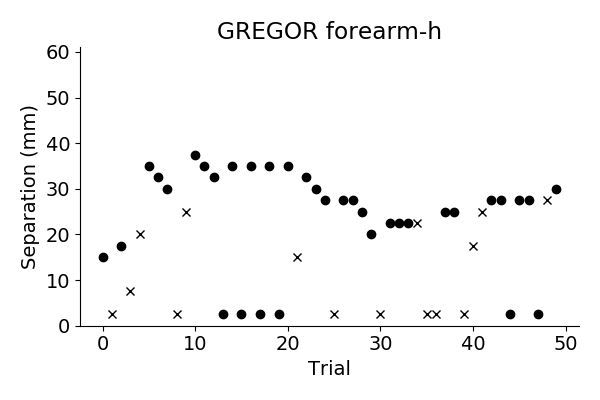

<IPython.core.display.Javascript object>


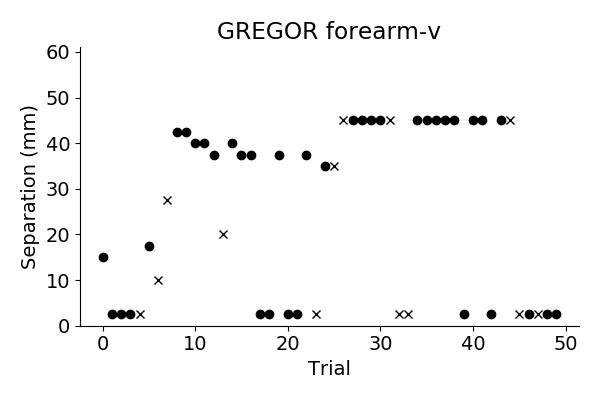

In [17]:
%matplotlib notebook

sepotrial(BS, "h")

sepotrial(BS, "v")

<IPython.core.display.Javascript object>


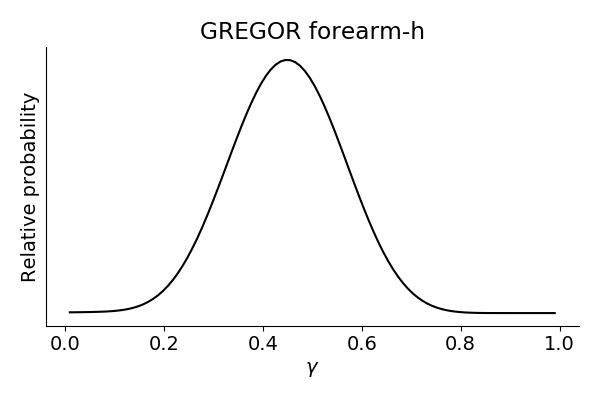

0.44794658269791265
0.45


<IPython.core.display.Javascript object>


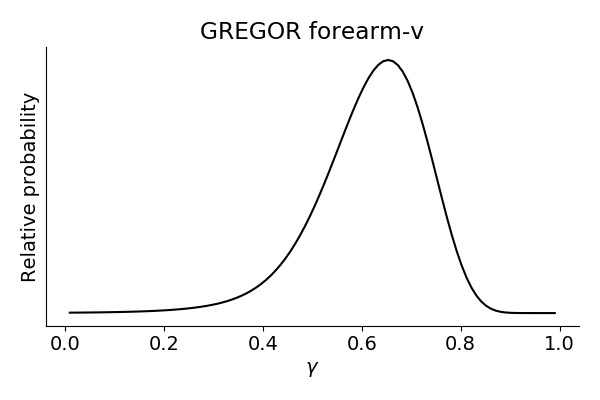

0.6187193756882599
0.65


In [18]:
%matplotlib notebook

pguessogam(BS, "h")

pguessogam(BS, "v")

<IPython.core.display.Javascript object>


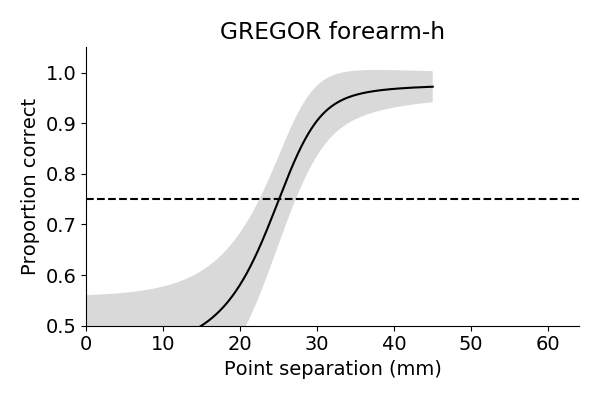

<IPython.core.display.Javascript object>


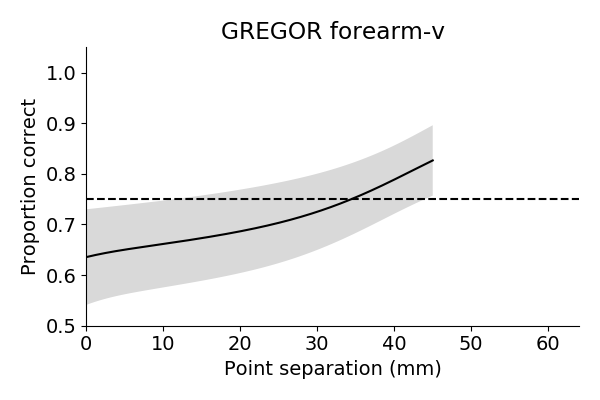

In [14]:
%matplotlib notebook

spline_h = propcorosep(BS, "h", 0.75, True, True)   #propcorosep(body site, hor or ver, hor line at value,  
                                                      #smoothing, interpolate to zero dist)
spline_h = propcorosep(BS, "v", 0.75, True, True)

#spline_v = propcorosep(BS, "v", 0.75, True, True)

In [15]:
print(thrshfromspln(spline_h, 0.75))

#print(thrshfromspln(spline_v, 0.75))

34.424


<IPython.core.display.Javascript object>


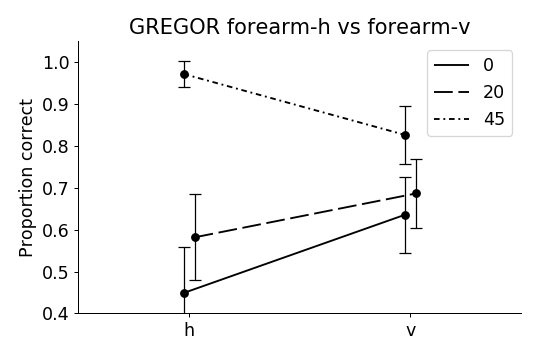

In [19]:
BS1 = BS
BS2 = BS

HV1 = "h"
HV2 = "v"

DOP = "d"
VALUES = [0, 20, 45]

#DOP = "p"
#VALUES = [0.6, 0.7, 0.8, 0.9]

thrshcompare(BS1, HV1, BS2, HV2, DOP, VALUES)